In [51]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import torch
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameter setup

Plotting

In [52]:
inferno_r = matplotlib.cm.inferno_r
cmap_hist = utils.shiftedColorMap(inferno_r, start=0.1, stop=1.0)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


## Load data

In [53]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = '_Mmin10.25'
mass_multiplier = 1e10
log_mass_shift = 10

In [54]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)

../configs/halos_TNG100-1_Mmin10.25.yaml


In [55]:
with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

# Load in objects; need no matter what feature type
sim_reader = SimulationReader(halo_params['sim']['base_dir'], halo_params['sim']['sim_name'], 
                              halo_params['sim']['sim_name_dark'], halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(halo_params['halo']['fn_dark_halo_arr'])
sim_reader.read_simulations() # TODO: do we need this step?

In [56]:
sim_reader.add_catalog_property_to_halos('m200m')
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_200m = np.log10(m_200m)

In [57]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [58]:
np.min(log_m_200m+log_mass_shift), np.max(log_m_200m+log_mass_shift)

(10.206749, 14.563137)

In [59]:
len(log_m_200m)

31409

Text(0, 0.5, 'number per bin')

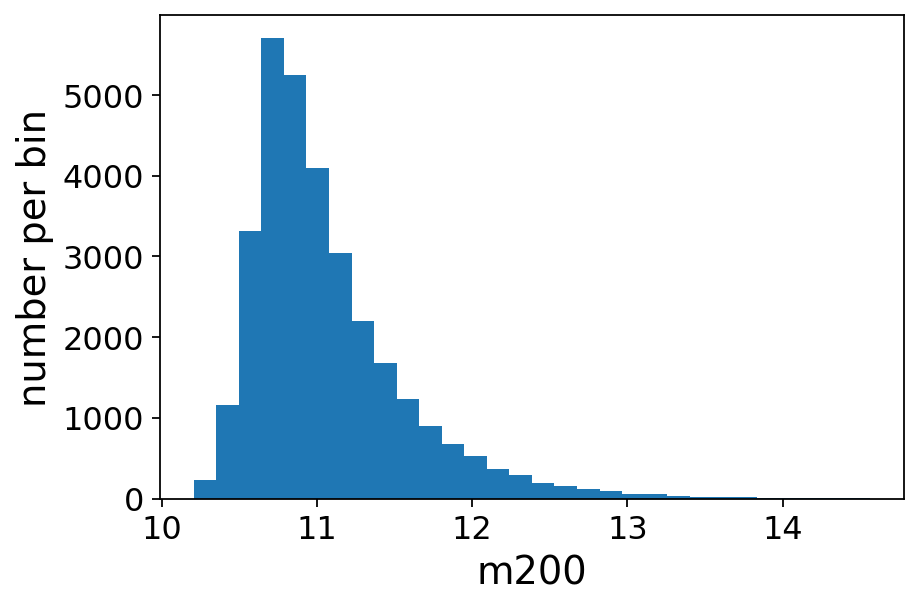

In [60]:
plt.hist(log_m_200m+log_mass_shift, bins=30)
plt.xlabel('m200')
plt.ylabel('number per bin')

# M stellar

In [73]:
x_label_name = 'm_200m'
y_label_name = 'm_stellar'
#fit_tag = f'_{y_label_name}_nn_scalars_epochs1000_lr5e-05_hs128'
#fit_tag = f'_{y_label_name}_hgboost_scalars_epochs300_lr0.1_hs128'
#fit_tag = f'_weighted{geo_tag}{scalar_tag}_{y_label_name}_hgboost_scalars_epochs300_lr0.1'
fit_tag = f'_n3_{y_label_name}_hgboost_scalars_epochs300_lr0.1'
#fit_tag = f'_weighted_{y_label_name}_hgboost_catalog_z0_epochs300_lr0.1'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [74]:
y_pred = np.load(fn_pred).ravel()

In [75]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
print(y_test_mult), print(y_pred_mult)
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"

x_property = log_m_200m[idx_test] + log_mass_shift

[12.1898155 11.910868  11.763318  ...  7.798315   7.6170216  7.785699 ]
[11.44566076 11.47886076 11.45202083 ...  7.85777309  7.81225133
  8.17817163]


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


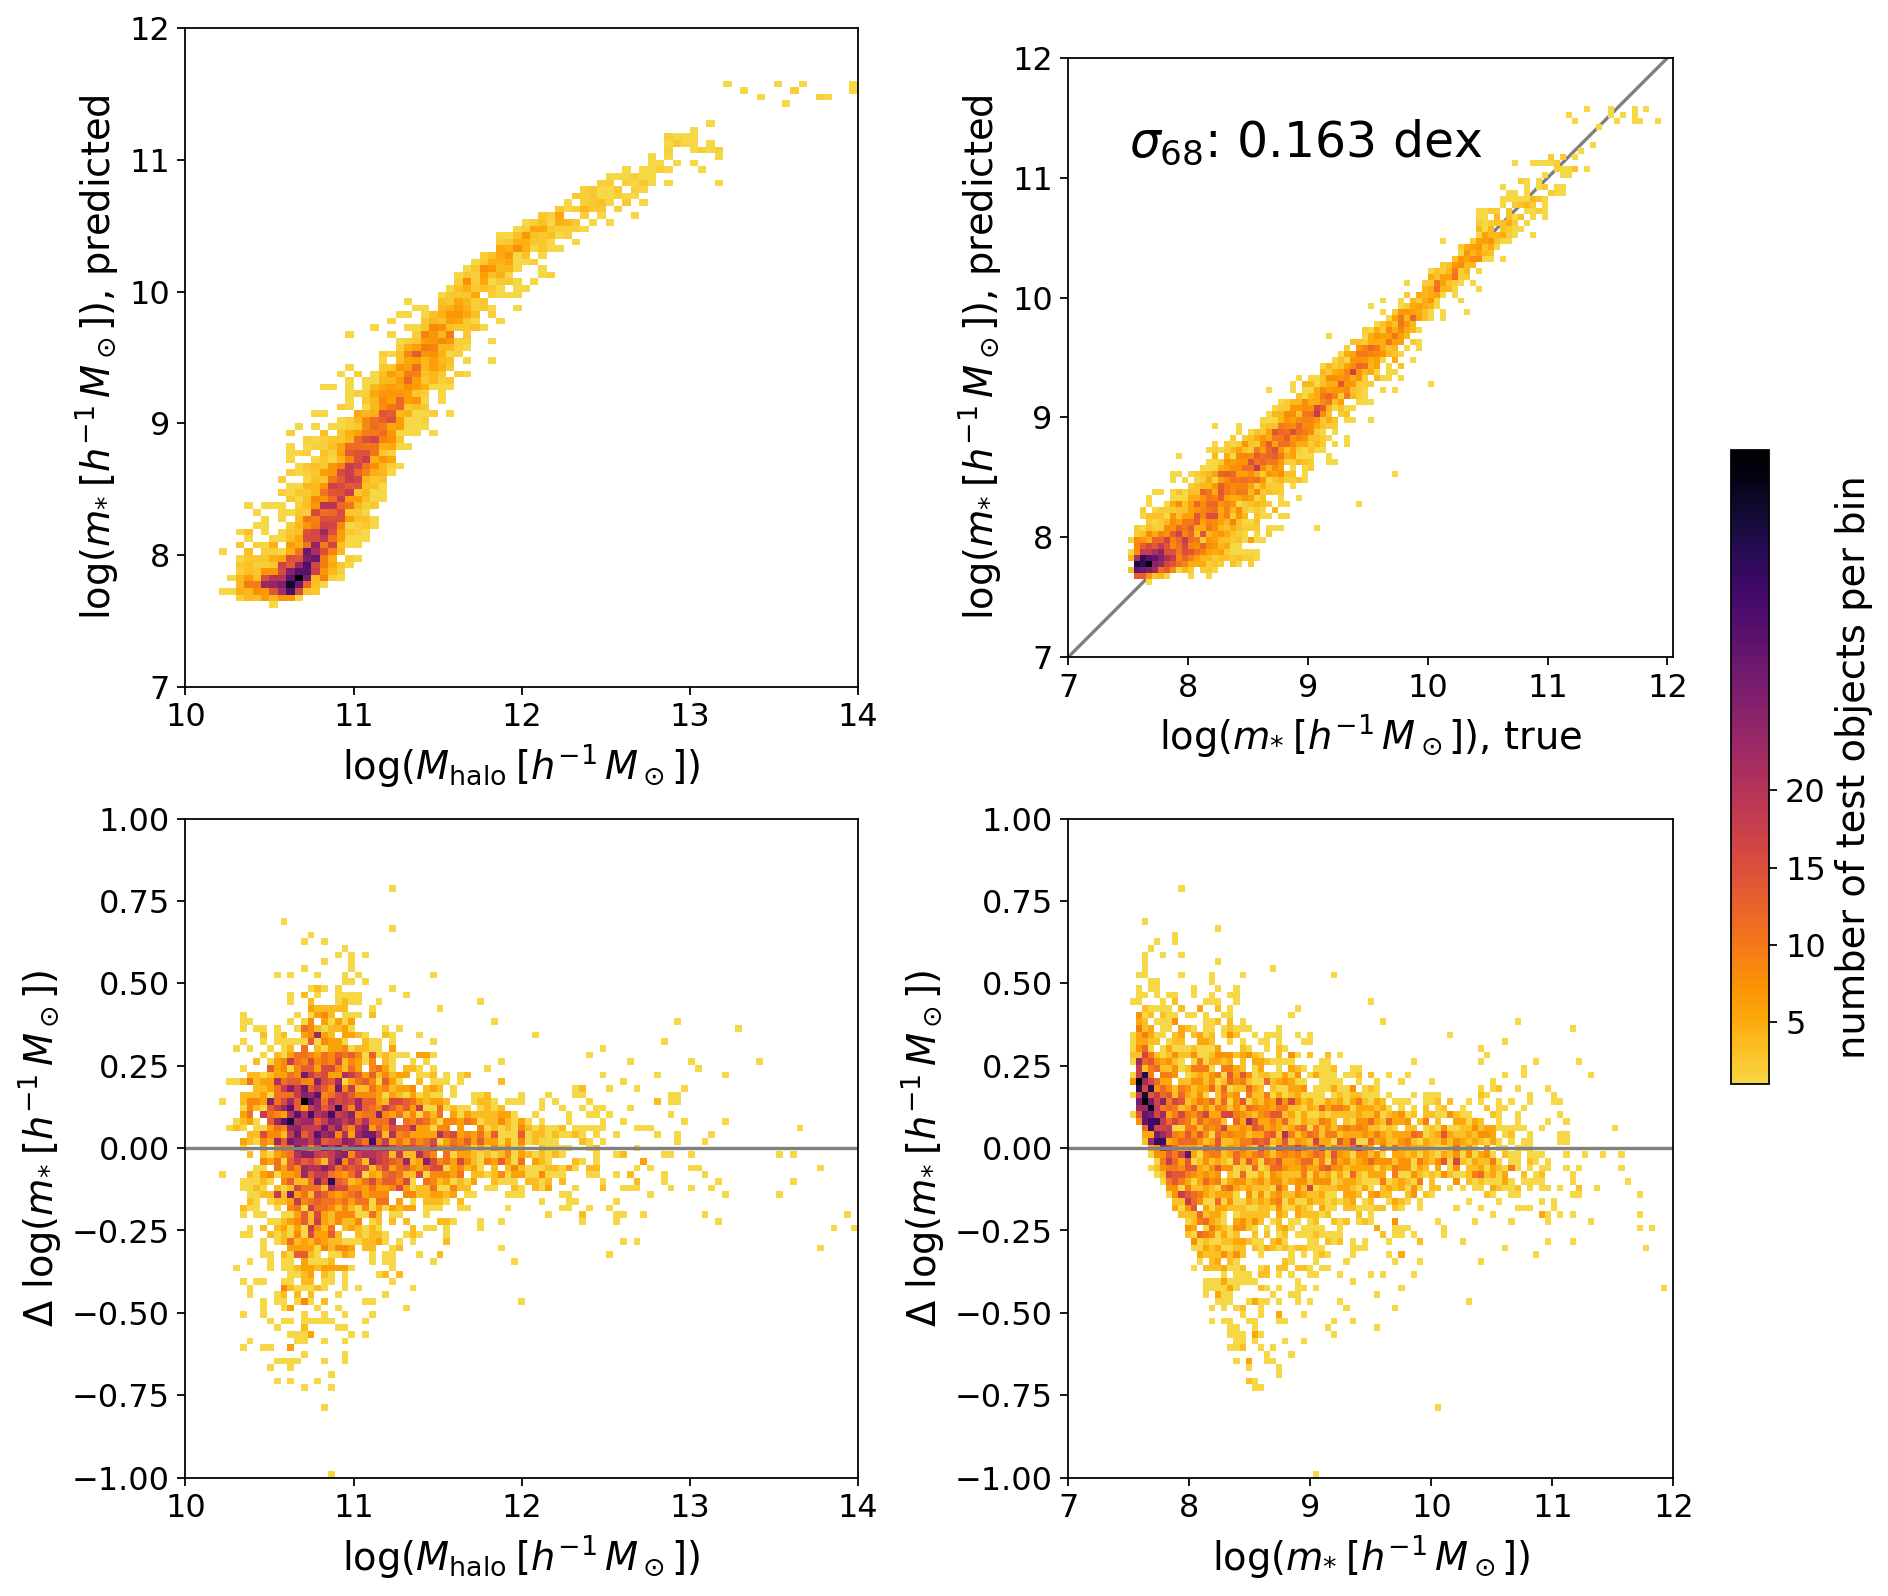

In [76]:
plotter.plot_multi_panel_pred(x_label_name, y_label_name, x_property, y_test_mult, y_pred_mult, 
                              text_results=error_str)

# Feature plots for Mstellar

In [82]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']
#feature_modes = ['scalars', 'geos', 'catalog_z0']

In [83]:
feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
print(feature_labels)

['Invariant scalar features', 'Geometric features', 'Standard halo features', 'M200, R200, V200']


In [84]:
y_pred_arr = []
text_results_arr = []
for i, feature_mode in enumerate(feature_modes):
    #fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    fit_tag = f'_{y_label_name}_hgboost_{feature_mode}_epochs300_lr0.1'
    if feature_mode=='scalars':
        fit_tag = '_n3'+fit_tag
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

    y_pred = np.load(fn_pred).ravel()
    y_pred_mult = y_pred + log_mass_shift
    y_pred_arr.append(y_pred_mult)
    
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    text_results_arr.append(error_str)

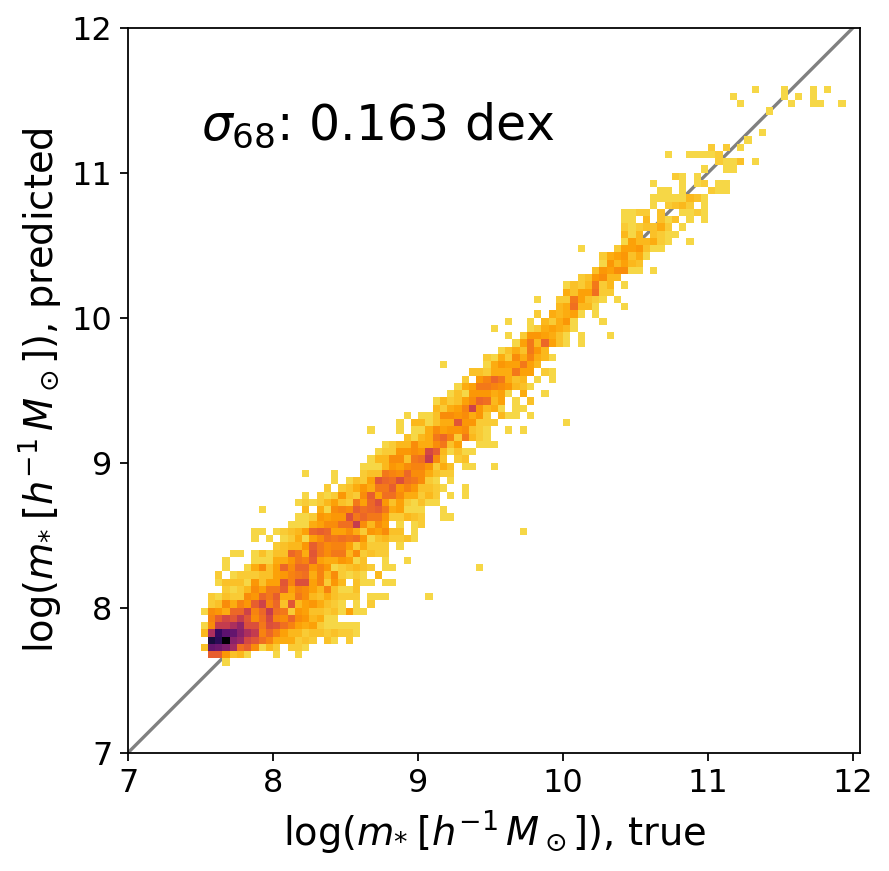

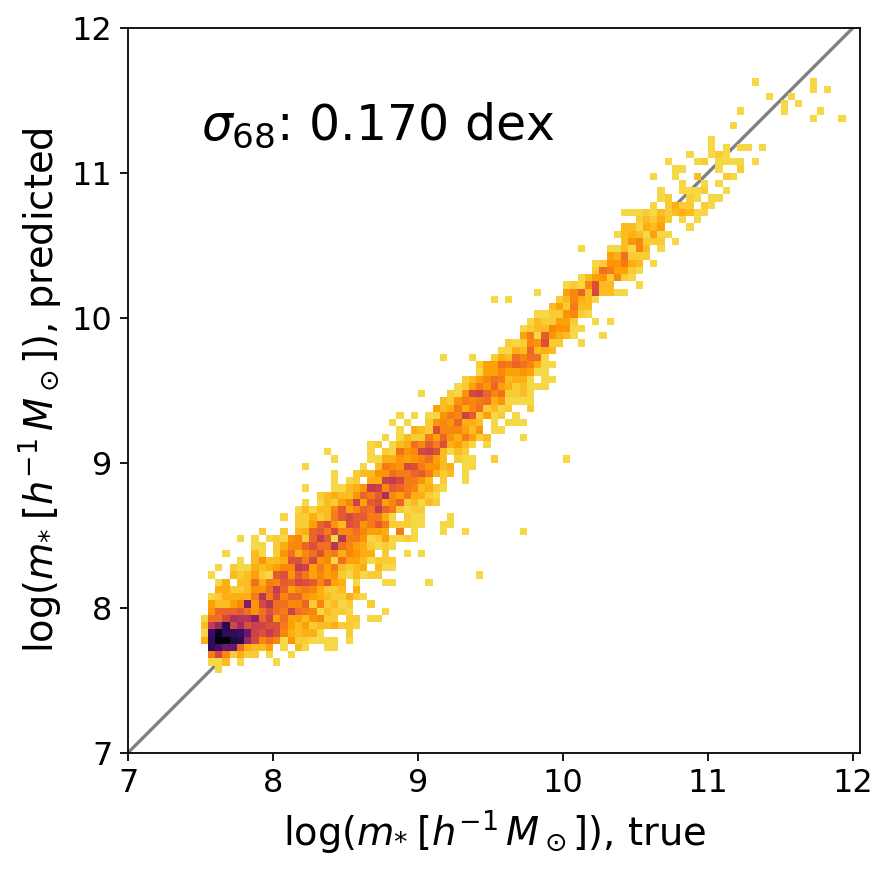

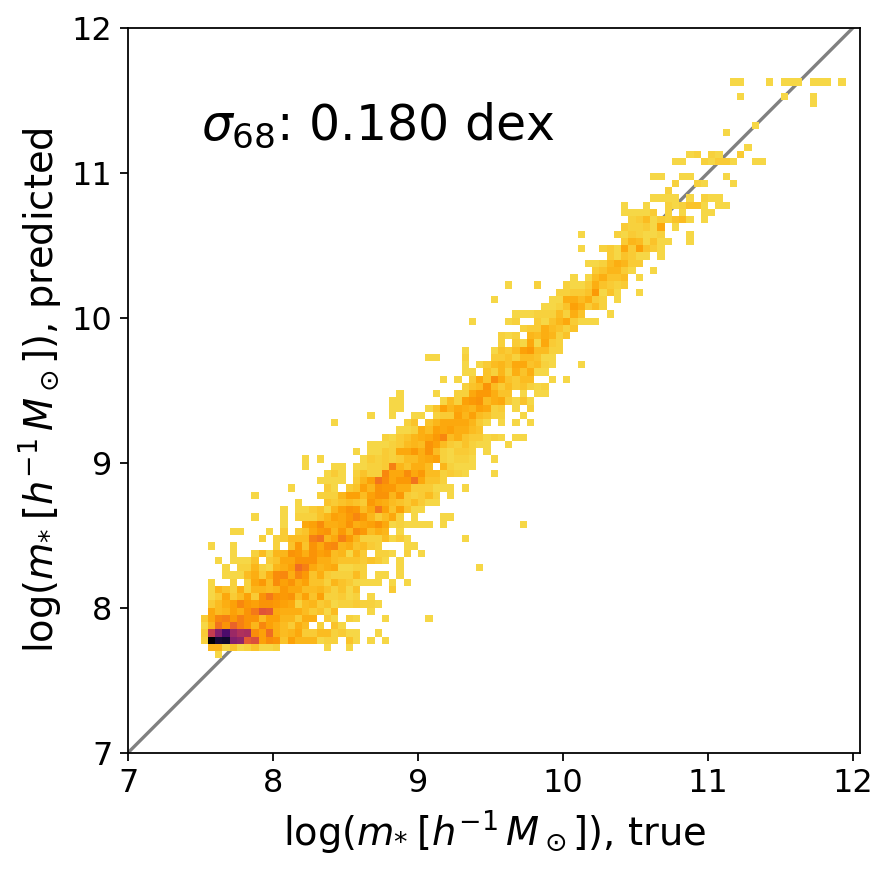

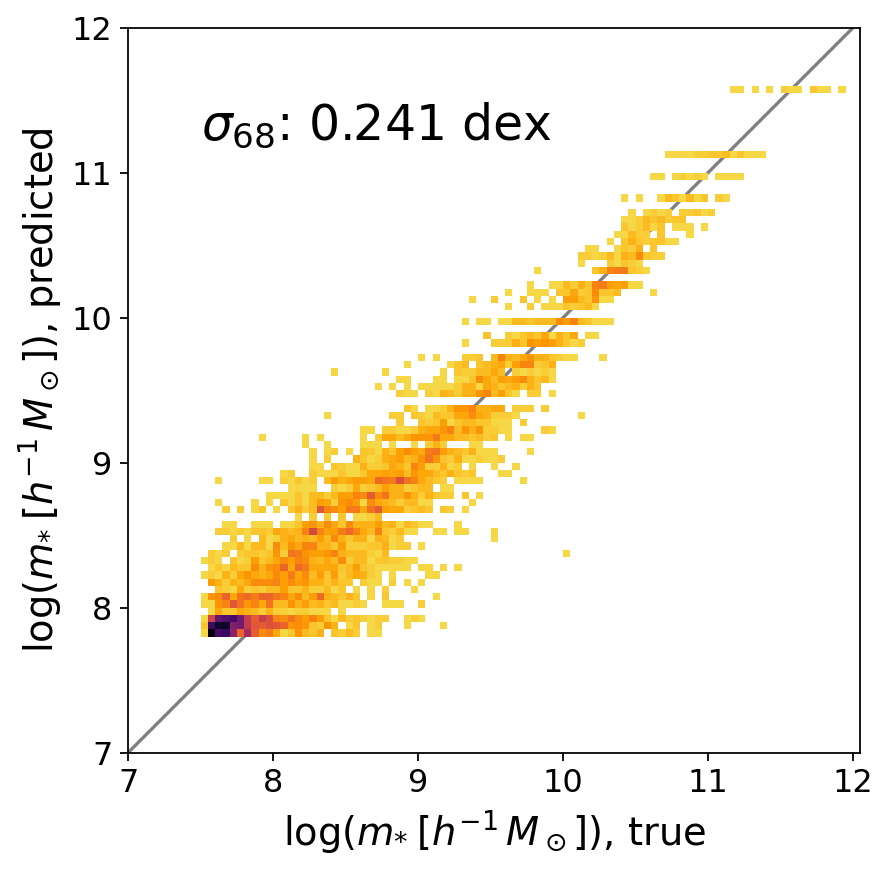

In [85]:
for i in range(len(y_pred_arr)):
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    y_pred = y_pred_arr[i]
    plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred, cmap_hist, text_results=text_results_arr[i])

### testing things

In [125]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
feature_modes = ['scalars', 'catalog_z0']
#feature_modes = ['catalog_z0']

In [126]:
feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
print(feature_labels)

['Invariant scalar features', 'Standard halo features']


In [127]:
y_pred_arr = []
text_results_arr = []
for i, feature_mode in enumerate(feature_modes):
    #fit_tag = f'_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
    #fit_tag = f'_scaleqt1000'
    fit_tag = ''
    if feature_mode=='geos':
        #fit_tag = '_bins10'+fit_tag
        fit_tag += '_bins10'
    if feature_mode=='scalars':
        #fit_tag = '_bins10_n3'+fit_tag
        fit_tag += '_bins10_n3'
    fit_tag += f'_{y_label_name}_nn_{feature_mode}_epochs500_lr0.01_hs128'
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    
    y_pred = np.load(fn_pred)
    y_pred_mult = y_pred + log_mass_shift
    y_pred_arr.append(y_pred_mult)
    
    error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    text_results_arr.append(error_str)

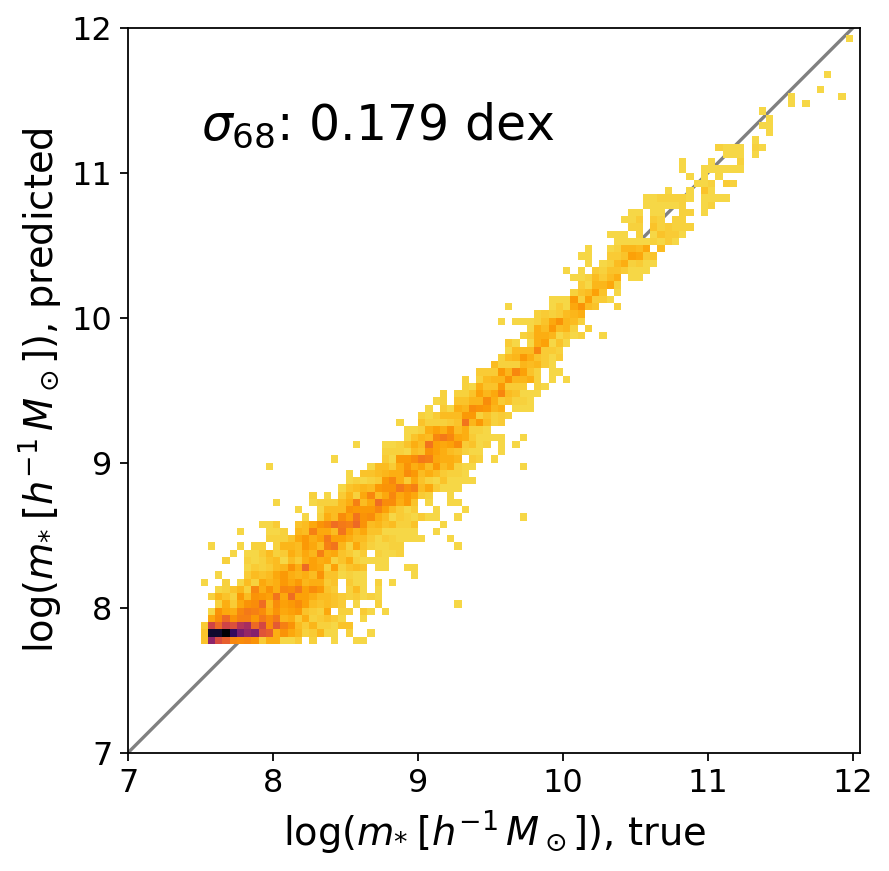

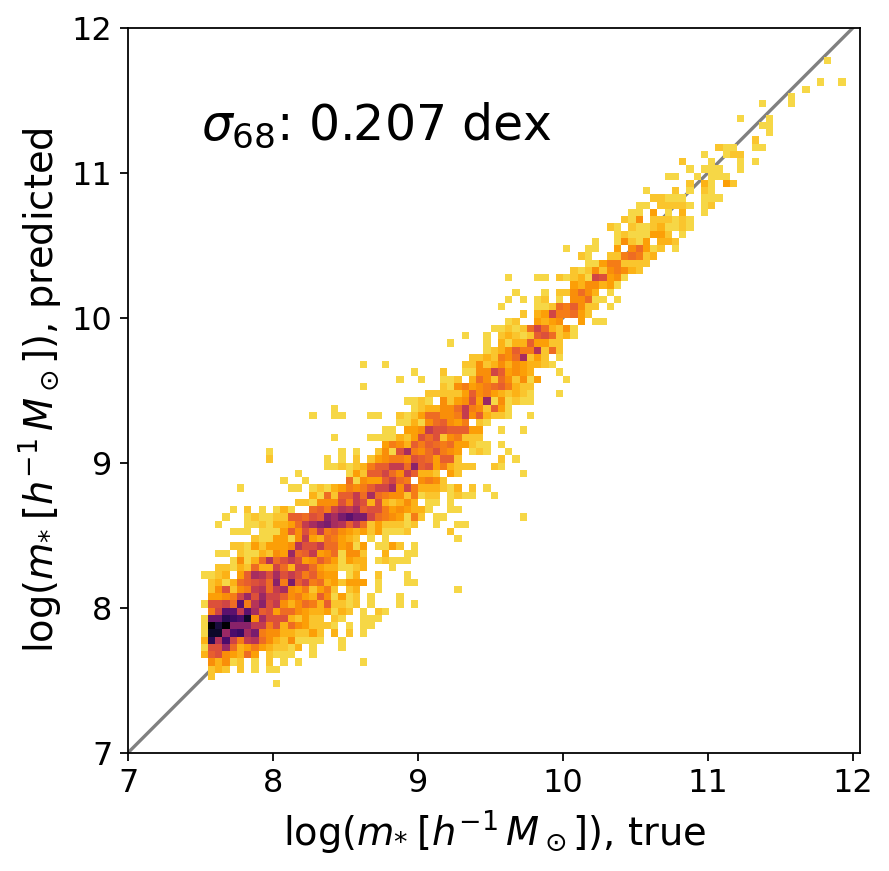

In [128]:
for i in range(len(y_pred_arr)):
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    y_pred = y_pred_arr[i]
    plotter.plot_pred_vs_true_hist(ax, y_label_name, y_test_mult, y_pred, cmap_hist, text_results=text_results_arr[i])

### Full plot

In [106]:
y_label_name = 'm_stellar'
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]
y_test_mult = y_test + log_mass_shift
feature_modes = ['scalars', 'geos', 'catalog_z0', 'mrv']
#feature_modes = ['scalars', 'catalog_z0', 'mrv']
#feature_modes = ['scalars']
#feature_modes = ['catalog_z0']

feature_label_dict = {'scalars': 'Invariant scalar features',
                      'geos': 'Geometric features',
                      'catalog_z0': 'Standard halo features',
                      'mrv': 'M200, R200, V200'}
feature_labels = [feature_label_dict[feature_mode] for feature_mode in feature_modes]
print(feature_labels)

['Invariant scalar features', 'Geometric features', 'Standard halo features', 'M200, R200, V200']


In [107]:
x_label_name = 'm_200m'
y_label_name_plot = ['m_stellar', 'ssfr1', 'r_stellar', 'gband_minus_iband', 'bhmass_per_mstellar', 'j_stellar']

y_label_name_arr = y_label_name_plot

y_label_name_train = '_'.join(y_label_name_arr)

y_true_arr = []
y_pred_arr = []
text_results_arr = []

j_fiducial = feature_modes.index('scalars')
#j_fiducial = feature_modes.index('catalog_z0')

y_pred_feat_arr = []
for j in range(len(feature_labels)):
    feature_mode = feature_modes[j]
    #fit_tag = '_weighted'
    fit_tag = ''
    if feature_mode=='geos':
        fit_tag += ''
    if feature_mode=='scalars':
        fit_tag += '_n3'
    #fit_tag += f'_{y_label_name_train}_tabnet_{feature_mode}_epochs500_lr0.02'
    #fit_tag += f'_{y_label_name_train}_rf_{feature_mode}'
    #fit_tag += f'_{y_label_name_train}_xgboost_{feature_mode}_lr0.01'
    fit_tag += f'_{y_label_name_train}_hgboost_{feature_mode}_epochs300_lr0.1'
    #fit_tag += f'_{y_label_name_train}_nn_{feature_mode}_epochs1000_lr0.01_hs128'
    fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
    fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'
    y_pred_all = np.load(fn_pred)
    print(y_pred_all.shape)
    y_pred_feat_arr.append(np.atleast_2d(y_pred_all))
    
y_pred_feat_arr = np.array(y_pred_feat_arr)
print(y_pred_feat_arr.shape)

y_lowerlim_arr = []    
for y_label_name in y_label_name_plot:
    i = y_label_name_arr.index(y_label_name)
    y = utils.get_y_vals(y_label_name, sim_reader)
    y_test = y[idx_test]
    y_pred = y_pred_feat_arr[j_fiducial,:,i]
    y_pred_feats = y_pred_feat_arr[:,:,i]
    if y_label_name=='m_stellar':
        y_test += log_mass_shift
        y_pred_feats += log_mass_shift
    error_nn, _ = utils.compute_error(y_test, y_pred, test_error_type='percentile')
    error_str = fr"$\sigma_{{68}}$: {error_nn:.3f} dex"
    
    x_bins, stdevs_binned = utils.get_butterfly_error(x_label_name, y_label_name, halo_logmass_min=10.2, n_bins=10)
    y_lowerlim_arr.append(stdevs_binned)
    
    y_true_arr.append(y_test)
    y_pred_arr.append(y_pred_feats)
    text_results_arr.append(error_str)

# x_bins_avg same for all, we'll just grab the last one
y_pred_arr = np.array(y_pred_arr)
print(y_pred_arr.shape)
x_property = log_m_200m[idx_test] + log_mass_shift

(4712, 6)
(4712, 6)
(4712, 6)
(4712, 6)
(4, 4712, 6)
Assuming y is logscale! (CHECK)
Assuming y is logscale! (CHECK)
Assuming y is logscale! (CHECK)
<KeysViewHDF5 ['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']>
Assuming y is logscale! (CHECK)
Assuming y is logscale! (CHECK)
Assuming y is logscale! (CHECK)
(6, 4, 4712)


In [108]:
frac_test = len(idx_test)/len(sim_reader.dark_halo_arr)
L_Mpc = sim_reader.box_size / 1000.0
weight = 1/(L_Mpc**3 * frac_test)
colorbar_label = 'galaxy number density\n'+r'[$h^{-1}$ Mpc)$^{-3}$ dex$^{-2}$]'

In [109]:
colors = ['black', 'maroon', 'lightseagreen', 'forestgreen']

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:366: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


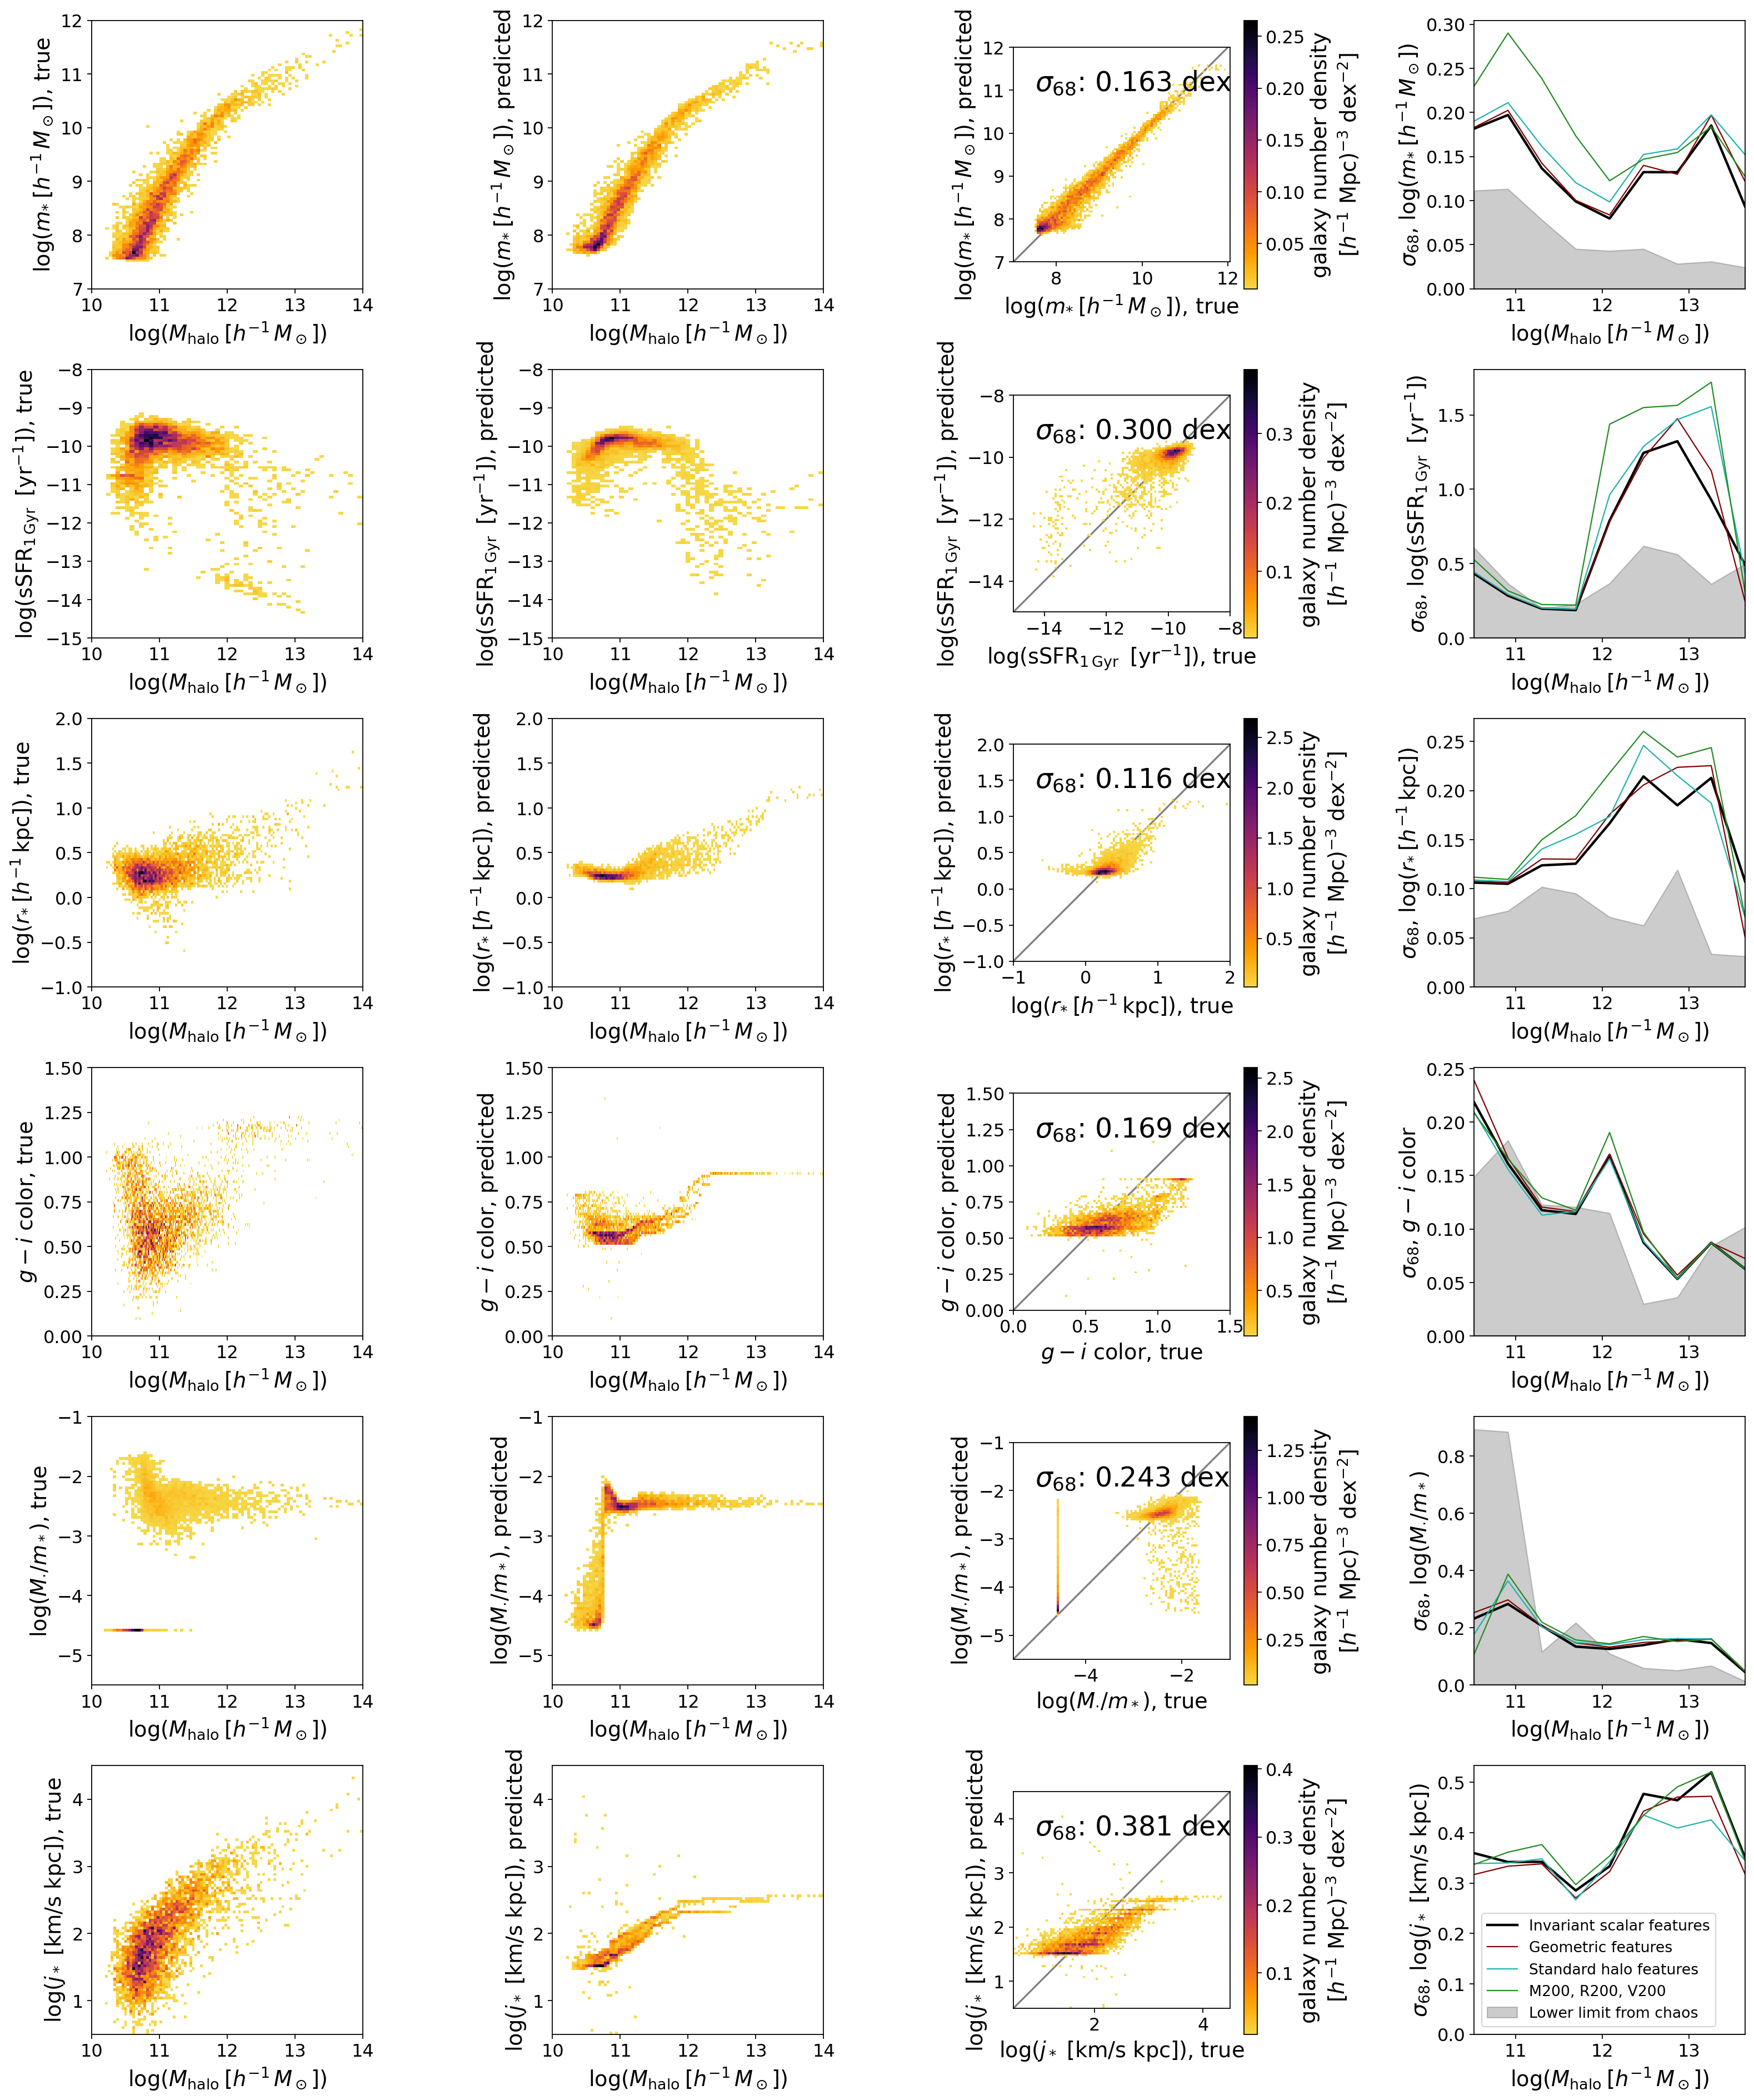

In [110]:
plotter.plot_multi_panel_gal_props_errors(x_label_name, y_label_name_plot, x_property, y_true_arr, y_pred_arr,
                                   feature_labels, colors,
                                   j_fiducial=j_fiducial,
                                   weight=weight, weight_by_dex=True, colorbar_label=colorbar_label,
                                   text_results_arr=text_results_arr,
                                   x_bins=x_bins, y_lowerlim_arr=y_lowerlim_arr)

# Mass Assembly History

### multi-panel plot

In [48]:
y_label_name = 'a_mfrac_n39'
feature_mode = 'scalars'
#fit_tag = f'_elementary_{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
fit_tag = f'__{y_label_name}_nn_{feature_mode}_epochs1000_lr5e-05_hs128'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{fit_tag}.pt'
fn_pred = f'../predictions/predictions_{sim_name}/predictions_{sim_name}{halo_tag}{fit_tag}.npy'

In [49]:
y_pred = np.load(fn_pred)
print(y_pred.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../predictions/predictions_TNG100-1/predictions_TNG100-1_Mmin10__a_mfrac_n39_nn_scalars_epochs1000_lr5e-05_hs128.npy'

In [50]:
y = utils.get_y_vals(y_label_name, sim_reader)
y_test = y[idx_test]

KeyError: 183

In [ ]:
n = y_label_name.split('_n')[-1]
mfrac_vals = utils.get_mfrac_vals(int(n)) # should include 1 or no? now does

In [ ]:
plotter.plot_a_mfrac_accuracy(y_pred, y_test, mfrac_vals, title='', n_show=8)

In [99]:
y = utils.get_y_vals('bhmass_per_mstellar', sim_reader=sim_reader)
print(np.min(y), np.max(y))
unc = utils.get_y_uncertainties('bhmass_per_mstellar', sim_reader=sim_reader)
print(np.min(unc), np.max(unc))

-4.569602966308594 -1.5622706413269043
0.07211102550927978 0.2720294101747089


In [100]:
y = utils.get_y_vals('bhmass', sim_reader=sim_reader)
print(np.min(y), np.max(y))
unc = utils.get_y_uncertainties('bhmass', sim_reader=sim_reader)
print(np.min(unc), np.max(unc))

-5.09691 -0.07658779
0.06 0.22
